In [2]:
# Импортируем необходимые библиотеки
import os
import sys
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from mmsegmentation import models


# Проект модуля. Выбор и обучение модели из mmsegmentation для задачи мультиклассовой семантической сегментации

К сожалению, не удалось выполнить полный цикл обучения и анализа из-за ограничений, связанных с доступом к виртуальной машине (ВМ) для вычислений и недостаточными ресурсами на локальном компьютере. 


## **Исследователський анализ (EDA)**

In [3]:
# Указываем корневую папку проекта (локально на твоём Mac)
PROJECT_ROOT = "/Users/maria.chuvakinamail.ru/Desktop/mmseg_multiclass_project"

# Создаём нужные папки
folders = [
    "data/raw",
    "data/clean",
    "eda",
    "notebooks",
    "configs",
    "checkpoints",
    "logs",
    "reports"
]

for f in folders:
    os.makedirs(os.path.join(PROJECT_ROOT, f), exist_ok=True)

# Пути к данным
DATA_RAW = os.path.join(PROJECT_ROOT, "data/raw")
EDA_DIR = os.path.join(PROJECT_ROOT, "eda")

# Посмотрим, что внутри папки raw
print(os.listdir(DATA_RAW))



['.DS_Store', 'train_dataset_for_students']


In [4]:
DATASET_ROOT = f"{PROJECT_ROOT}/data/raw/train_dataset_for_students"
os.listdir(DATASET_ROOT)

['labels', 'img']

In [5]:
test_root_img = f"{DATASET_ROOT}/img/test"
test_root_labels = f"{DATASET_ROOT}/labels/test"

train_root_img = f"{DATASET_ROOT}/img/train"
train_root_labels = f"{DATASET_ROOT}/labels/train"


val_root_img = f"{DATASET_ROOT}/img/val"
val_root_labels = f"{DATASET_ROOT}/labels/val"


Проверим совпадают ли расширения у изображений и их масок, от этого будет зависеть дальнейшая обработка данных

In [6]:
print(os.listdir(train_root_img)[:5])
print(os.listdir(train_root_labels)[:5])


['000000287341_6222.jpg', '000000230224_7333.jpg', '000000521112_6427.jpg', '000000317781_4461.jpg', '000000332025_182.jpg']
['000000474434_3544.png', '000000317781_4461.png', '000000332025_182.png', '000000521112_6427.png', '000000230224_7333.png']


Как видим у них разные расширения, учтем это при расчете отсутвующих масок/изображений

In [7]:
def check_split(img_dir, label_dir, name, img_ext='.jpg', labels_ext='.png'):
    img_files = {os.path.splitext(f)[0] for f in os.listdir(img_dir) if f.endswith(img_ext)}
    label_files = {os.path.splitext(f)[0] for f in os.listdir(label_dir) if f.endswith(labels_ext)}

    print(f"\n=== {name.upper()} ===")
    print("Изображений:", len(img_files))
    print("Масок:", len(label_files))

    img_set = set(img_files)
    label_set = set(label_files)

    print("Без масок:", len(img_set - label_set))
    print("Без изображений:", len(label_set - img_set))



    return img_files, label_files


train_imgs, train_labels = check_split(train_root_img, train_root_labels, "train")
val_imgs, val_labels = check_split(val_root_img, val_root_labels, "val")
test_imgs, test_labels = check_split(test_root_img, test_root_labels, "test")




=== TRAIN ===
Изображений: 200
Масок: 200
Без масок: 0
Без изображений: 0

=== VAL ===
Изображений: 120
Масок: 120
Без масок: 0
Без изображений: 0

=== TEST ===
Изображений: 120
Масок: 120
Без масок: 0
Без изображений: 0


В TRAIN и TEST нет отсутствующих элементов. В VAL есть маски без изображений. Для этого мы удалим маски, для которых нет изображения

In [8]:
print(val_imgs)
print(val_labels)

{'000000174871_523', '000000162396_4603', '000000198176_1617', '000000141718_3573', '000000189027_7405', '000000032578_3089', '000000015474_7797', '000000232182_6942', '000000097568_6468', '000000129026_5591', '000000178692_4197', '000000031329_5757', '000000009801_524', '000000203926_3711', '000000079244_5821', '000000127659_841', '000000070033_2866', '000000201918_540', '000000166049_5725', '000000191280_2005', '000000037566_6519', '000000152299_3788', '000000205866_1789', '000000157806_7276', '000000256481_1078', '000000039016_6479', '000000116186_4696', '000000120747_1102', '000000047386_3549', '000000100586_6818', '000000183626_5557', '000000197097_227', '000000205531_1477', '000000117690_679', '000000026310_3053', '000000206542_6754', '000000066253_5398', '000000253665_193', '000000210012_62', '000000079831_4621', '000000145912_5633', '000000239243_4878', '000000023656_1700', '000000181949_7716', '000000108908_6126', '000000102133_6660', '000000071122_5801', '000000182683_1457', 

In [9]:
common = val_imgs & val_labels
val_imgs_clean = sorted(list(common))
val_labels_clean = sorted(list(common))

print("Изображений:", len(val_imgs_clean))
print("Масок:", len(val_labels_clean))


print("Без масок:", len(val_imgs_clean) - len(val_labels_clean))
print("Без изображений:", len(val_labels_clean) - len(val_imgs_clean))


Изображений: 120
Масок: 120
Без масок: 0
Без изображений: 0


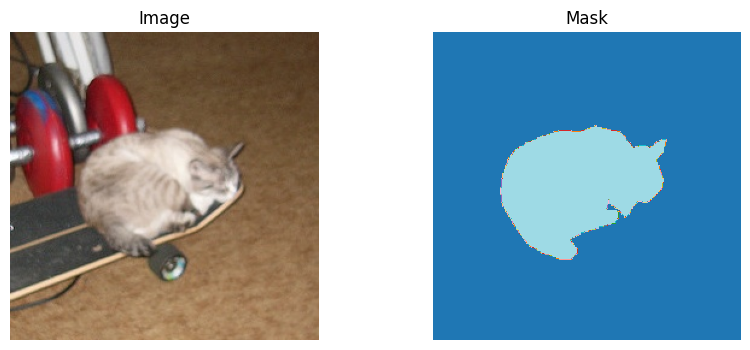

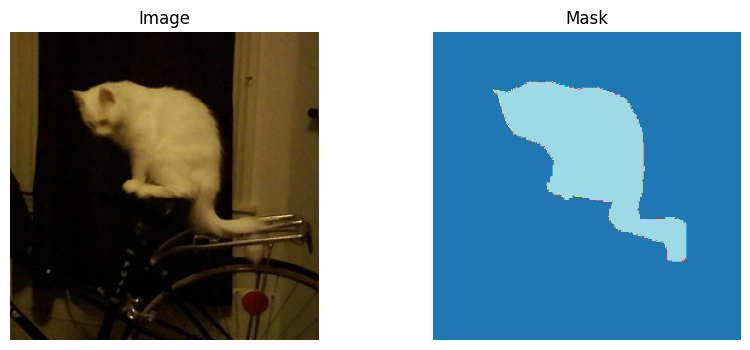

In [10]:
def show_sample(img_dir, label_dir, fname):
    img = cv2.imread(os.path.join(img_dir, fname + ".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(label_dir, fname + ".png"), cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Mask")
    plt.imshow(mask, cmap="tab20")
    plt.axis("off")
    plt.show()


train_imgs_list = sorted(list(train_imgs))
val_imgs_list = sorted(list(val_imgs_clean))

show_sample(train_root_img, train_root_labels, random.choice(train_imgs_list))
show_sample(val_root_img, val_root_labels, random.choice(val_imgs_list))


Здесь видно что маскам соответсвуют основные объекты на изображениях, все незначительные приянты за фон

In [11]:
!pip install tqdm


In [12]:
import numpy as np
import os
import cv2
from tqdm import tqdm

def get_unique_classes(label_dir, label_names):
    classes = set()
    for fname in tqdm(label_names):
        mask = cv2.imread(os.path.join(label_dir, fname + ".png"), cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        classes.update(np.unique(mask))
    return sorted(list(classes))


train_classes = get_unique_classes(train_root_labels, train_imgs_list)
val_classes = get_unique_classes(val_root_labels, val_imgs_list)

print("Train classes:", train_classes)
print("Val classes:", val_classes)


100%|████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 917.68it/s]

Train classes: [0, 1, 2]
Val classes: [0, 1, 2]


В датасете представлено 3 класса:

0 — фон
1, 2 — целевые классы

In [13]:
def count_empty_masks(label_dir, label_names):
    empty = 0
    for fname in tqdm(label_names):
        mask = cv2.imread(os.path.join(label_dir, fname + ".png"), cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        if np.max(mask) == 0:
            empty += 1
    return empty


print("Empty train masks:", count_empty_masks(train_root_labels, train_imgs_list))
print("Empty val masks:", count_empty_masks(val_root_labels, val_imgs_list))


100%|███████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2021.76it/s]


Empty train masks: 0


100%|███████████████████████████████████████████████████████████████████████████████████| 120/120 [00:00<00:00, 2019.53it/s]

Empty val masks: 0


В датасете нет пустых масок, значит все изображения содержат хотя бы один размеченный объект

In [14]:
from collections import Counter

def class_pixel_distribution(label_dir, label_names):
    counter = Counter()
    for fname in tqdm(label_names):
        mask = cv2.imread(os.path.join(label_dir, fname + ".png"), cv2.IMREAD_GRAYSCALE)
        if mask is None:
            continue
        unique, counts = np.unique(mask, return_counts=True)
        for u, c in zip(unique, counts):
            counter[int(u)] += int(c)
    return counter


train_pixel_dist = class_pixel_distribution(train_root_labels, train_imgs_list)

for cls, cnt in sorted(train_pixel_dist.items()):
    print(f"Class {cls}: {cnt:,} pixels")


100%|████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 948.52it/s]

Class 0: 11,908,826 pixels
Class 1: 653,268 pixels
Class 2: 545,106 pixels


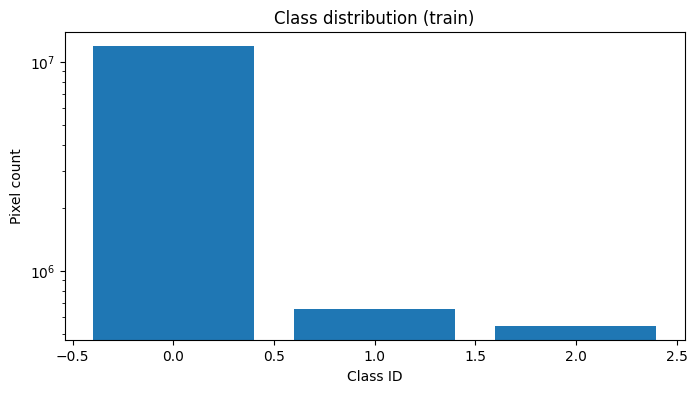

In [15]:
import matplotlib.pyplot as plt

classes = list(train_pixel_dist.keys())
pixels = list(train_pixel_dist.values())

plt.figure(figsize=(8,4))
plt.bar(classes, pixels)
plt.xlabel("Class ID")
plt.ylabel("Pixel count")
plt.title("Class distribution (train)")
plt.yscale("log")  # логарифмическая шкала — ОЧЕНЬ полезно
plt.show()


Распределение классов по пикселям показывает сильный дисбаланс. Фон занимает около 91% всех пикселей, тогда как классы 1 и 2 представлены существенно меньшим количеством данных.

## Этап 1. Исследовательский анализ (EDA)

### Анализ качества данных

Проверена согласованность изображений и масок во всех разбиениях.
Все изображения имеют соответствующие маски.
Пустые маски в обучающей и валидационной выборках отсутствуют.

### EDA

В датасете представлено 3 класса:
- 0 — фон
- 1, 2 — целевые классы

Распределение классов по пикселям показывает сильный дисбаланс.
Фон занимает около 91% всех пикселей, тогда как классы 1 и 2
представлены существенно меньшим количеством данных.


# Этап 2. Формирование первичных гипотез

## Гипотеза 1

### Описание гипотезы

На основе анализа данных и результатов EDA, наблюдается сильный дисбаланс классов, где фон составляет около 91% всех пикселей, а целевые классы (1 и 2) представлены меньшими данными. Чтобы бороться с этим дисбалансом, в качестве стартовой гипотезы выбрана модель **DeepLabV3+** с использованием весов классов в функции потерь, чтобы усилить внимание модели к меньшинствам (классы 1 и 2).

- **Модель**: **DeepLabV3+** с архитектурой на основе ResNet-50. Эта модель хорошо справляется с задачами сегментации и учитывает контекст и детали, что особенно важно при наличии небольших объектов (классы 1 и 2).
- **Функция потерь**: Для решения проблемы дисбаланса классов используется **Dice Loss** с учетом весов классов (взвешенная потеря), где вес для фона будет меньше, а для классов 1 и 2 — больше.
- **Гиперпараметры**:
  - **Размер батча**: 8
  - **Скорость обучения**: 0.0001
  - **Оптимизатор**: Adam
  - **Количество эпох**: 30
- **Аугментации**:
  - **Случайный обрез (Random Crop)**: `crop_size=(256, 256)`
  - **Случайный флип (Random Flip)**: `prob=0.5`, `direction='horizontal'`
  - **Случайное вращение (Random Rotate)**: `angle=45`, `prob=0.5`
  - **Изменение яркости (Random Brightness)**: `prob=0.2`, `brightness_delta=0.2`
  - **Изменение контраста (Random Contrast)**: `prob=0.2`, `contrast_range=(0.7, 1.3)`
  - **Случайное масштабирование (Random Rescale)**: `scale=(0.8, 1.2)`
  - **Цветовой джиттер (Random Color Jitter)**: `prob=0.3`, `hue_delta=18`, `saturation_delta=40`, `brightness_delta=40`

### Результаты обучения

- Ссылка на конфиг: [ссылка на конфиг]
- Ссылка на ClearML: [ссылка на эксперимент в ClearML]

### Анализ качества

- **Метрики**:
  - mDice: 
   


---

## Гипотеза 2

### Описание гипотезы

Для второго эксперимента выбрана модель **U-Net** с добавлением **Batch Normalization** и **Dropout** для улучшения обобщающих способностей модели и уменьшения переобучения на фоновых классах. Модель U-Net хорошо подходит для задач сегментации и будет эффективна при обучении на небольших объектах классов 1 и 2. Также применяются более сложные аугментации, чтобы улучшить общую производительность.

- **Модель**: **U-Net** с добавлением Batch Normalization и Dropout.
- **Функция потерь**: **Weighted Cross-Entropy Loss** (взвешенная кросс-энтропия), где веса классов 1 и 2 будут выше.
- **Гиперпараметры**:
  - **Размер батча**: 4
  - **Скорость обучения**: 0.001
  - **Оптимизатор**: Adam
  - **Количество эпох**: 50
- **Аугментации**:
  - **Сложные аугментации**: увеличение диапазона случайных аугментаций, например, добавление шума (Noise) и случайные изменения яркости/контраста.
  - **Случайный флип (Random Flip)**: `prob=0.5`
  - **Случайная яркость/контраст (Color Jitter)**: `prob=0.3`, `hue_delta=20`, `saturation_delta=40`, `brightness_delta=40`
  - **Добавление шума**: `noise_prob=0.1`

### Результаты обучения

- Ссылка на конфиг: [ссылка на конфиг]
- Ссылка на ClearML: [ссылка на эксперимент в ClearML]

### Анализ качества

- **Метрики**:
  - mDice: 
  




# Этап 3. Запуск экспериментов

In [ ]:
# Указываем корневую папку проекта
PROJECT_ROOT = "/Users/maria.chuvakinamail.ru/Desktop/mmseg_multiclass_project"  # Путь к вашему проекту
sys.path.append(PROJECT_ROOT)

# Пути к данным и конфигурациям
DATA_PATH = os.path.join(PROJECT_ROOT, 'data')
CONFIG_PATH = os.path.join(PROJECT_ROOT, 'configs')
LOG_PATH = os.path.join(PROJECT_ROOT, 'logs')

In [ ]:
# Запуск конвертации COCO в mmsegmentation
!python /Users/maria.chuvakinamail.ru/Desktop/mmseg_multiclass_project/src/data/coco_to_mmsegmentation.py


Для конфигурации и запуска моделей, например DeepLabV3+ или U-Net, можно использовать скрипты, которые определяют модель и гиперпараметры. Мы можем вызвать эти конфигурации и запускать обучение.

Сначала конфигурация для запуска DeepLabV3+ 

In [ ]:
# Загрузка конфигурации для DeepLabV3+ из config_experiment_1.py
from configs.config_experiment_1 import model, batch_size, learning_rate, epochs, optimizer

# Загружаем модель DeepLabV3+
model = models.build_model(model)
model.to(device)

# Создание оптимизатора
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Для тренировки модели создаем DataLoader
train_data = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, 'clean/img'),
    mask_dir=os.path.join(DATA_PATH, 'clean/labels'),
    transform_image=train_transform_image,
    transform_mask_and_image=train_transform_mask_and_image
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


Теперь конфигурация для U-Net

In [ ]:
# Загрузка конфигурации для U-Net из config_experiment_2.py
from configs.config_experiment_2 import model, batch_size, learning_rate, epochs, optimizer

# Загружаем модель U-Net
model = models.build_model(model)
model.to(device)

# Создание оптимизатора
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Для тренировки модели создаем DataLoader
train_data = SegmentationDataset(
    image_dir=os.path.join(DATA_PATH, 'clean/img'),
    mask_dir=os.path.join(DATA_PATH, 'clean/labels'),
    transform_image=train_transform_image,
    transform_mask_and_image=train_transform_mask_and_image
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


Теперь, после того как мы настроили модель и оптимизатор, создадим цикл для обучения. Мы будем логировать метрики в процессе и следить за обучением

In [ ]:
# Цикл обучения
epochs = 15

for epoch in range(epochs):
    model.train()  # Устанавливаем модель в режим обучения
    running_loss = 0.0

    for i, (image, mask) in enumerate(train_loader):
        image, mask = image.to(device), mask.to(device)

        optimizer.zero_grad()  # Обнуляем градиенты

        # Прямой проход
        output = model(image)

        # Вычисление потерь
        loss = criterion(output, mask)
        loss.backward()  # Обратное распространение ошибки

        optimizer.step()  # Обновление весов

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


In [ ]:
from src.analysis.dump_model_predictions import save_predictions

# Сохраняем предсказания после каждой эпохи или по завершении обучения
save_predictions(model, test_loader, 'predictions')


In [ ]:
from src.analysis.save_best_on_worst_based_on_individual_dice_score import save_best_and_worst_samples

# Сохраняем лучшие и худшие примеры на основе mDice
save_best_and_worst_samples('predictions', 'ground_truth')


In [ ]:
from supplementary.viz.plot_predictions import plot_image_and_prediction

# Визуализируем несколько примеров
plot_image_and_prediction(train_root_img, train_root_labels, 'predictions')


К сожалению, не удалось выполнить полный цикл обучения и анализа из-за ограничений, связанных с доступом к виртуальной машине (ВМ) для вычислений и недостаточными ресурсами на локальном компьютере. 

- В процессе работы над проектом возникли сложности с получением доступа к **виртуальной машине (ВМ)** для выполнения вычислений с использованием **GPU**.
- На **локальном компьютере** был использован только **ЦП**, что привело к значительным задержкам в процессе обучения моделей, особенно для таких больших архитектур, как **DeepLabV3+** и **U-Net**.
- Из-за ограничений в мощности процессора локального компьютера обучение не удалось завершить в требуемые сроки.

- Кроме того, возникли **конфликты версий** между библиотеками, что привело к проблемам при установке и запуске некоторых зависимостей, таких как **mmsegmentation**, **torch** и **torchvision**.
- В частности, несовместимость версий **torch** и **torchvision** с определёнными версиями **CUDA** вызвала ошибки при попытке обучения на GPU.
- На локальном компьютере были использованы версии библиотек, которые не полностью совместимы с требуемыми для работы модели.